## SNR and Uniformity of Oil filled Siemens 32 Channel Head Coil

In [1]:
from __future__ import division, print_function

%matplotlib inline
from IPython.display import display

import matplotlib.pyplot as plt
plt.style.use('bmh')

import numpy as np
import pandas as pd

from mriqa.phantoms import phantom_mask_2d, find_phantom, OILSPHERE
from mriqa.dcmio import fetch_series, t_r, t_e, num_frames, seq_name, pix_spacing_yx, protocol_name
from mriqa.dcmio import approx_slice_orientation, approx_phase_orientation, rx_coil_name, phase_enc_dirn
from mriqa.tools import mean_im, diff_im, snr_im, snr, uniformity_ipem80, show_mosaic

#### Fetch Images and Show Some Sequence Parameters

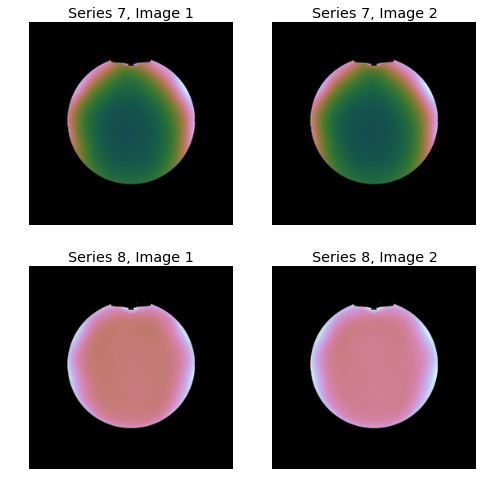

Frames    = 1
TR/TE     = 1000 / 30 ms
Matrix    = 256 x 256
Sequence  = *se2d1
FoV       = 250 x 250 mm
Bandwidth = 130 Hz
Phase Enc.= ROW
Protocol  = SE_AXIAL_RL_SNR_UNIF_HEAD_OIL20CM_PSN


In [2]:
# Study details
patid = 'PQA20150330RHD'
stuid = '1'

# Each series is a pair of acquisitions, the first series is un-normalised the second normalised
sernos = [7]
sernos_norm = [8]
dobjs = fetch_series(patid, stuid, sernos, 'CRIC')
dobjs_norm = fetch_series(patid, stuid, sernos_norm, 'CRIC')
show_mosaic(dobjs + dobjs_norm)
plt.show()

# Acquisition parameters
d = dobjs[0]
tr = t_r(d)
te = t_e(d)
pixspacing = pix_spacing_yx(d)
print('Frames    = %d'         % num_frames(d))
print('TR/TE     = %d / %d ms' % (tr, te))
print('Matrix    = %d x %d'    % (d.Rows, d.Columns))
print('Sequence  = %s'         % seq_name(d))
print('FoV       = %d x %d mm' % (d.Rows * pixspacing[0], d.Columns * pixspacing[1]))
print('Bandwidth = %d Hz'      % d.PixelBandwidth)
print('Phase Enc.= %s'         % phase_enc_dirn(d))
print('Protocol  = %s'         % protocol_name(d))

#### SNR from Mean and Paired-Difference Images

To get the SNR ratio we subtract the images in pairs to get the Noise and take the mean to get the Signal. Notice that the second pair of images with *clear* normalisation is somewhat flatter than the unnormalised one; the head coil is quite surface biased.

The SNR is the average over an ROI encompassing most of the phantom.

In [3]:
# Mean and diff of un-normalised images.
mean_image, diff_image = mean_im(*dobjs), diff_im(*dobjs)

fig, axs = plt.subplots(1, 4, figsize=(16, 4))

axs[0].imshow(mean_image, cmap='bone')
axs[0].axis('image')
axs[0].axis('off')
axs[0].set_title(r'Mean Image (Raw)')

mask = phantom_mask_2d(mean_image, mode='Erode')
mask = np.ma.masked_where(mask == 0, np.ones(mask.shape))
axs[0].imshow(mask, cmap='flag', alpha=0.25)

axs[1].imshow(diff_image, vmin=np.min(diff_image)/10, vmax=np.max(diff_image)/10, cmap='coolwarm')
axs[1].axis('image')
axs[1].axis('off')
axs[1].set_title(r'Difference Image (Raw)')

# Mean and diff of prescan-normalised images.
mean_image, diff_image = mean_im(*dobjs_norm), diff_im(*dobjs_norm)

axs[2].imshow(mean_image, cmap='bone')
axs[2].axis('image')
axs[2].axis('off')
axs[2].set_title(r'Mean Image (Normalised)')

mask = phantom_mask_2d(mean_image, mode='Erode')
mask = np.ma.masked_where(mask == 0, np.ones(mask.shape))
axs[2].imshow(mask, cmap='flag', alpha=0.25)

axs[3].imshow(diff_image, vmin=np.min(diff_image)/10, vmax=np.max(diff_image)/10, cmap='coolwarm')
axs[3].axis('image')
axs[3].axis('off')
axs[3].set_title(r'Difference Image (Normalised)')
plt.show()

# SNR calculations
print('Signal to Noise Ratio:')
print('    Un-normalized Images      = %5.0f' % snr(*dobjs))
print('    Prescan Normalized Images = %5.0f' % snr(*dobjs_norm))

Signal to Noise Ratio:
    Un-normalized Images      =   214
    Prescan Normalized Images =   239


#### IPEM Report 80 Fractional Uniformity Analysis

We look at a (thick) profile through the centre of the phantom and determine the length of the longest run that is within 10% of the modal value. The centre of the phantom is determined using a centroid method. Note that this is over the relatively small field of view of this phantom.

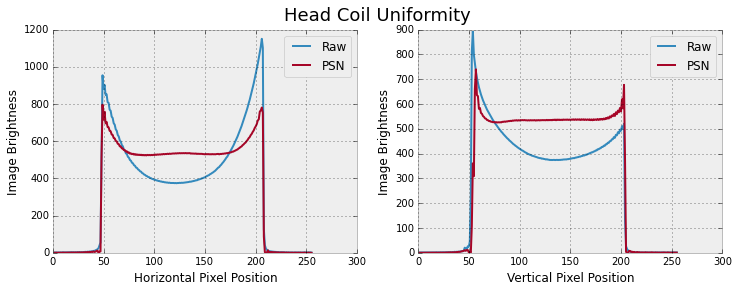

IPEM 80 Uniformity:
    Fractional Uniformity (Raw) (X) =  37%
    Fractional Uniformity (Raw) (Y) =  48%
    Fractional Uniformity (PSN) (X) =  79%
    Fractional Uniformity (PSN) (Y) =  93%


In [4]:
# Profiles and Uniformity calculation
profile_x_raw, uniformity_x_raw, profile_y_raw, uniformity_y_raw = uniformity_ipem80(*dobjs)
profile_x_psn, uniformity_x_psn, profile_y_psn, uniformity_y_psn = uniformity_ipem80(*dobjs_norm)

fig, axs = plt.subplots(1, 2, figsize=(12, 4))

axs[0].plot(profile_x_raw, label='Raw')
axs[0].hold(True)
axs[0].plot(profile_x_psn, label='PSN')
axs[0].set_xlabel('Horizontal Pixel Position')
axs[0].set_ylabel('Image Brightness')
axs[0].legend()
axs[0].grid(True)

axs[1].plot(profile_y_raw, label='Raw')
axs[1].hold(True)
axs[1].plot(profile_y_psn, label='PSN')
axs[1].set_xlabel('Vertical Pixel Position')
axs[1].set_ylabel('Image Brightness')
axs[1].legend()
axs[1].grid(True)

fig.suptitle('Head Coil Uniformity', fontsize=18)
plt.show()

print('IPEM 80 Uniformity:')
print('    Fractional Uniformity (Raw) (X) = %3.0f%%' % uniformity_x_raw)
print('    Fractional Uniformity (Raw) (Y) = %3.0f%%' % uniformity_y_raw)
print('    Fractional Uniformity (PSN) (X) = %3.0f%%' % uniformity_x_psn)
print('    Fractional Uniformity (PSN) (Y) = %3.0f%%' % uniformity_y_psn)
